In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from keras import Model
import os
import cv2
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt

In [2]:

class Dataset(tf.Module):
    def __init__(self,img_dir,mask_dir,transform = None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(img_dir)
        self.masks = os.listdir(mask_dir)
    
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        
        img_pth = os.path.join(self.img_dir,self.images[index])
        mask_pth = os.path.join(self.mask_dir,self.masks[index])
        
        image = cv2.imread(img_pth)
        image = image/255
        
        mask = cv2.imread(mask_pth)
        mask = mask/255
        
        
        image = np.array(image)
        mask = np.array(mask,dtype=np.float32)
        
        image = cv2.resize(image,(256,256))
        mask = cv2.resize(mask,(256,256))
        
        
#         image = np.expand_dims(image,axis=0)
#         mask = np.expand_dims(mask,axis=0)
        
        if self.transform is not None:
            augment = self.transform(image = image, mask=mask)
            image = augment['image']
            mask = augment['mask']
            
        return image, mask
    

In [3]:
def downsample(filters,  strides ,batchnorm=True):
    
    x = Sequential()
    
    x.add(Conv2D(filters, 5, strides=strides ,padding='same',use_bias=False))
    
    if batchnorm:
        x.add(BatchNormalization())
        
    x.add(LeakyReLU())
    
    return x


In [4]:
def upsample(filters, strides=2 ,dropout=False):
    
    x = Sequential()
    
    x.add(Conv2DTranspose(filters, 5,strides =strides ,padding='same',use_bias=False))
    
    if dropout==True:
        x.add(Dropout(0.2))
        
    x.add(ReLU())
    
    return x

In [5]:
def Generator():
    
    model = Sequential([
        Conv2D(3,5,strides=1,padding='same',use_bias=False,input_shape=(256,256,3)),
        downsample(16, 2),
        downsample(32, 2),
        downsample(64, 2),
        downsample(128, 2),
        downsample(256, 2),
        downsample(512, 2),
        downsample(512, 2),
#         downsample(512, 2),
#         upsample(512, 2),
        upsample(512, 2),
        upsample(512, 2),
        upsample(256, 2),
        upsample(128, 2),
        upsample(64,  2),
        upsample(32, 2),
        upsample(3, 2),
#         Conv2D(3, 5, strides=1, padding='same'),
    ])
        
    return model

In [6]:
# Generator().summary()

In [7]:
def Discriminator():
    
    model = Sequential([
        Conv2D(3,5,strides=1,padding='same',use_bias=False,input_shape=(256,256,3)),
        downsample(512, 2),
        downsample(256, 2),
        downsample(128, 2),
        downsample(64, 2),
        downsample(32, 2),
        downsample(16, 2),
        downsample(8, 2),
        downsample(1, 2),
    ])
    
    
    return model

In [8]:
gen_g = Generator()
gen_f = Generator()
disc_x = Discriminator()
disc_y = Discriminator()
disc_x_optimizer = tf.keras.optimizers.Adam()
disc_y_optimizer = tf.keras.optimizers.Adam()
gen_g_optimizer = tf.keras.optimizers.Adam()
gen_f_optimizer = tf.keras.optimizers.Adam()


In [9]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def disc_loss(real, gen):
    real_loss = loss_obj(real, np.ones_like(real))
    gen_loss = loss_obj(gen, np.zeros_like(gen))
    tot = (real_loss+gen_loss)/2
    return tot


def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10 * loss1

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 10 * 0.5 * loss

In [10]:
d1p='../input/clthes/train/cloth'
d2p='../input/clthes/train/image'
epochs=15

In [45]:
def train(x , y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = gen_g(x, training=True)
        cycle_x = gen_f(fake_y, training=True)
    
        fake_x = gen_f(y, training=True)
        cycle_y = gen_g(fake_x, training=True)
    
        same_x = gen_f(x, training=True)
        same_y = gen_g(y, training=True)
    
        disc_real_x = disc_x(x, training=True)
        disc_real_y = disc_y(y, training=True)
    
        disc_fake_x = disc_x(fake_x, training=True)
        disc_fake_y = disc_y(fake_y, training=True)
    
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
    
        total_cyc_loss = calc_cycle_loss(x,cycle_x) + calc_cycle_loss(y,cycle_y)
    
        total_gen_g_loss = (gen_g_loss + total_cyc_loss + identity_loss(y, same_y))
        total_gen_f_loss = (gen_f_loss + total_cyc_loss + identity_loss(x, same_x))
    
        disc_x_loss = disc_loss(disc_real_x, disc_fake_x)
        disc_y_loss = disc_loss(disc_real_y, disc_fake_y)
    
        gen_g_gradient = tape.gradient(total_gen_g_loss, gen_g.trainable_variables)
        gen_f_gradient = tape.gradient(total_gen_f_loss, gen_f.trainable_variables)
    
        disc_x_gradient = tape.gradient(disc_x_loss, disc_x.trainable_variables)
        disc_y_gradient = tape.gradient(disc_y_loss, disc_y.trainable_variables)
    
        gen_g_optimizer.apply_gradients(zip(gen_g_gradient, gen_g.trainable_variables))
        gen_f_optimizer.apply_gradients(zip(gen_f_gradient, gen_f.trainable_variables))
    
        disc_x_optimizer.apply_gradients(zip(disc_x_gradient, disc_x.trainable_variables))
        disc_y_optimizer.apply_gradients(zip(disc_y_gradient, disc_y.trainable_variables))
    
        
        return {'disc_x_loss':disc_x_loss, 'disc_y_loss':disc_y_loss}

In [48]:
for epoch in range(epochs):
    count=0
    for x,y in Dataset(d1p,d2p):
        train(np.expand_dims(x,axis=0),np.expand_dims(y,axis=0))
        count += 1
        if count % 10 ==0:
            print(count,'epoch:',epoch)
    print('next epoch',epoch+1)

In [13]:
h=[]
z=[]
count = 0
for i,j in Dataset(d1p,d2p):
    h.append(i)
    z.append(j)
    count += 1
    if count == 100:
        break
        
h= np.array(h)
z= np.array(z)
h.shape

(100, 256, 256, 3)

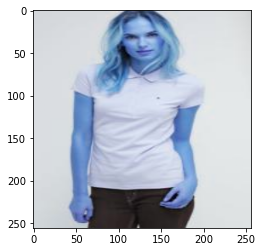

In [41]:
n=95
pred = gen_g(np.expand_dims(z[n],axis=0))
pred1 = gen_f(np.expand_dims(pred[0],axis=0))
plt.imshow(z[n])

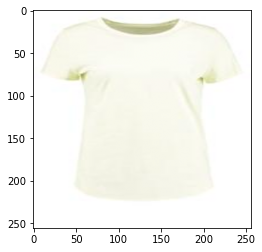

In [42]:
plt.imshow(h[n])

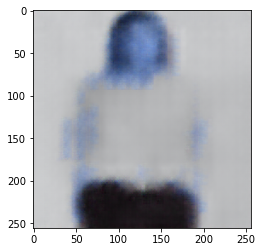

In [43]:
plt.imshow(pred[0])

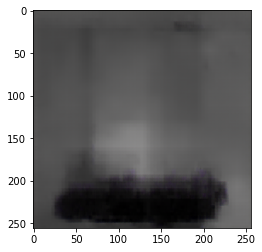

In [44]:
plt.imshow(pred1[0])

In [ ]:
# pred1*255